# IXIS Data Science Challenge

Elizabeth Miller

June 27, 2023

## 1 - Introduction

Given 2 datasets, we want to create two actionable reports for the business. First, we want a xlsx sheet containing a month and device aggregation with metrics including Sessions, Transactions, QTY, and ECR (Transactions / Sessions). Next, we want an xlsx sheet that's a Month over Month comparison for the most recent 2 months with all available metrics (including Adds to Cart) showing: the most recent month's value, the prior month's value, and both the absolute and relative differences between them. 

In order to do these with python3, we'll need the holy trinity of python packages. 

In [1]:
#The Holy Trinity

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Handy code to remove warnings

import warnings
warnings.filterwarnings("ignore")

Any project is broken into the following phases:

1. Defining the Problem
2. Data Investigation & Cleaning
3. Exploratory Data Analysis
4. Answering the Problem (Modeling)
5. Findings
6. Deploying

**Note:** For this project, we will not be completing step 6 as we were just tasked with reports. 

### Defining the Problem

Based on the two required reports, it seems this business, we'll call it Fictional, needs a snapshot of their records monthly. First, as a simple monthly report showing business transaction metrics and secondly, as a month over month analysis of their various metric values. 

At first glance, this appears to be a Data Analysis project and not a machine learning question so we will leave those algorithms out and instead focus on whether the past few months' analysis can provide actionable insights for Fictional. 

## 2 - Data Investigation and Cleaning

To begin, let's take a quick look at the data provided. First, we'll need to read in the files. This will be done in a stepwise manner. First we'll focus on the Session Counts csv: dig through it and clean it up. Then we will go back and do the same for the Adds To Cart csv. 

### Session Counts

In [2]:
#Reading in the csv

sessioncounts = pd.read_csv("sessioncounts.csv")
sessioncounts.head()

,dim_browser,dim_deviceCategory,dim_date,sessions,transactions,QTY
0,Safari,tablet,7/1/12,2928,127,221
1,Internet Explorer,desktop,7/1/12,1106,28,0
2,Chrome,tablet,7/1/12,474,3,13
3,Amazon Silk,tablet,7/1/12,235,4,5
4,Internet Explorer,mobile,7/1/12,178,6,11


Next, let's look at the data holistically. 

In [3]:
#Checking basic column info

sessioncounts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7734 entries, 0 to 7733
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   dim_browser         7734 non-null   object
 1   dim_deviceCategory  7734 non-null   object
 2   dim_date            7734 non-null   object
 3   sessions            7734 non-null   int64 
 4   transactions        7734 non-null   int64 
 5   QTY                 7734 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 362.7+ KB


There are 6 columns with 7,734 rows. There are no null values so this data is pretty clean and we will not be imputing. Based on the first 5 rows, there also does not appear to be any junk columns so we do not need to drop anything. 

However, the names of the columns are not very clean with the dim_ prefix. This is done in many data warehouse naming conventions for tables where the data is slowly changing and contains context or background information. Since the bottom 3 columns do not have the dim_ prefix, it is likely that they come from a separate table and were joined together. For the sake of readability, let's rename those top 3 columns and remove the prefix.

In [4]:
#Renaming

sessioncounts.rename(columns = {'dim_browser':'browser', 'dim_deviceCategory':'device', 'dim_date':'date'}, inplace = True)

Just to check it is done. 

In [5]:
#Checking the names

sessioncounts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7734 entries, 0 to 7733
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   browser       7734 non-null   object
 1   device        7734 non-null   object
 2   date          7734 non-null   object
 3   sessions      7734 non-null   int64 
 4   transactions  7734 non-null   int64 
 5   QTY           7734 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 362.7+ KB


Now QTY does not fit in the overall naming convention. Let's change that too. 

In [6]:
#Renaming

sessioncounts.rename(columns = {'QTY':'quantity'}, inplace = True)

When we initially ran the info() code, it stated that the date column is the dtype object. As it's a date, it should have the datetime dtype. Let's recast that. 

In [7]:
#Recast date column as a date

sessioncounts['date'] = pd.to_datetime(sessioncounts['date'])

In [8]:
#Checking dtype

sessioncounts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7734 entries, 0 to 7733
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   browser       7734 non-null   object        
 1   device        7734 non-null   object        
 2   date          7734 non-null   datetime64[ns]
 3   sessions      7734 non-null   int64         
 4   transactions  7734 non-null   int64         
 5   quantity      7734 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 362.7+ KB


One last thing. We can quickly check what is in the non-metric columns and make sure there isn't any junk hidden within them. 

In [9]:
#Getting all data from this column

sessioncounts['browser'].value_counts()

Chrome                                  679
Internet Explorer                       673
Safari                                  669
Edge                                    535
Firefox                                 522
Safari (in-app)                         476
Opera                                   471
Android Webview                         458
Samsung Internet                        380
Amazon Silk                             366
error                                   364
Android Browser                         351
BlackBerry                              224
SeaMonkey                               204
Opera Mini                              161
UC Browser                              155
Mozilla                                 143
Maxthon                                 127
YaBrowser                               121
Puffin                                   99
(not set)                                98
Mozilla Compatible Agent                 93
osee2unifiedRelease             

Looks like there *is* some junk with the error and (not set) values. Error accounts for 364 and (not set) is 98. Combined, this makes up 6% of the overall data. When working with clients, it's important to get their input into what to do with this type of data. In lieu of that for this project, we will leave it for now since it is a small percent of the data. Once presented to the client, this can be something to discuss. Let's check the other 2 non-metric columns.

In [10]:
#Getting all data from this column

sessioncounts['device'].value_counts()

mobile     3013
desktop    2672
tablet     2049
Name: device, dtype: int64

This is clean and all values make sense. 

With this, the Session Counts csv is clean, renamed and the dtypes are all correct. Let's move on to doing the same to the Adds to Cart csv. 

### Adds To Cart

We will follow the same steps as before, beginning with reading in the data and looking at the first 5 rows. 

In [11]:
#Reading in the csv

addstocart = pd.read_csv("addstocart.csv")
addstocart.head()

,dim_year,dim_month,addsToCart
0,2012,7,191504
1,2012,8,217666
2,2012,9,123726
3,2012,10,139803
4,2012,11,186572


This is straight forward, we have a date (year and month) and then a value for addsToCart. Since the values for addsToCart are not decimals, we can assume this is the number of times items were added to the cart. Now let's get an overview of the data.

In [12]:
#Getting holistic view

addstocart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   dim_year    12 non-null     int64
 1   dim_month   12 non-null     int64
 2   addsToCart  12 non-null     int64
dtypes: int64(3)
memory usage: 416.0 bytes


There are 12 rows, so 12 months being tracked with this table. There are no null values. The first thing we need to do is to combine the year and month columns to make a dtype datetime column. This will be useful when comparing this table to the Session Counts data. To do this, we need to rename those two columns to 'year' and 'month' as these are special strings that pandas looks for when converting to datetime. 

In [13]:
#Renaming

addstocart.rename(columns = {'dim_year':'year', 'dim_month':'month', 'addsToCart':'addstocart'}, inplace = True)
addstocart.head()

,year,month,addstocart
0,2012,7,191504
1,2012,8,217666
2,2012,9,123726
3,2012,10,139803
4,2012,11,186572


In [14]:
#Now merging the two into a datetime column. 

addstocart['date'] = pd.to_datetime(addstocart[['year', 'month']].assign(DAY=1))
addstocart.head()

,year,month,addstocart,date
0,2012,7,191504,2012-07-01
1,2012,8,217666,2012-08-01
2,2012,9,123726,2012-09-01
3,2012,10,139803,2012-10-01
4,2012,11,186572,2012-11-01


Now we need to rearrange the order of some columns and the date column to match the previous dataset's "m/d/Y" format. This may not prove necessary but it will provide a way to join the two datasets together when analyzing (if the dates align). I will also drop the year and month column as they are no longer necessary. 

In [15]:
#Changing date format

addstocart['date'] = addstocart['date'].dt.strftime("%m/%d/%Y")
addstocart

,year,month,addstocart,date
0,2012,7,191504,07/01/2012
1,2012,8,217666,08/01/2012
2,2012,9,123726,09/01/2012
3,2012,10,139803,10/01/2012
4,2012,11,186572,11/01/2012
5,2012,12,168972,12/01/2012
6,2013,1,147619,01/01/2013
7,2013,2,135882,02/01/2013
8,2013,3,109797,03/01/2013
9,2013,4,183842,04/01/2013


In [16]:
#Recasting back as date 

addstocart['date'] = pd.to_datetime(addstocart['date'])

In [17]:
#Dropping month & year

addstocart = addstocart.drop(['month', 'year'], axis=1)


#Checking it's gone
addstocart.head()

,addstocart,date
0,191504,2012-07-01
1,217666,2012-08-01
2,123726,2012-09-01
3,139803,2012-10-01
4,186572,2012-11-01


In [18]:
#Changing the order of the columns

addstocart=addstocart.iloc[:,[1,0]]
addstocart

,date,addstocart
0,2012-07-01,191504
1,2012-08-01,217666
2,2012-09-01,123726
3,2012-10-01,139803
4,2012-11-01,186572
5,2012-12-01,168972
6,2013-01-01,147619
7,2013-02-01,135882
8,2013-03-01,109797
9,2013-04-01,183842


Now the addstocart dataset is clean and ready for analysis. 

## 3 - Exploratory Data Analysis

We looked at the data a bit with the info and describe commands but need to take a deeper dive into the data to truly understand it. 

### Session Counts

In [19]:
#Inspect

sessioncounts.head()

,browser,device,date,sessions,transactions,quantity
0,Safari,tablet,2012-07-01,2928,127,221
1,Internet Explorer,desktop,2012-07-01,1106,28,0
2,Chrome,tablet,2012-07-01,474,3,13
3,Amazon Silk,tablet,2012-07-01,235,4,5
4,Internet Explorer,mobile,2012-07-01,178,6,11


Looking at the first 5 rows gives us some good information. This is clearly a list of internet browsers, the device used to browse, the date accessed, the number of sessions, transactions and quantity during those sessions. From this we can deduce that each row is likely a different individual's data for that specific date. There does not seem to be any identifying column for the individual though (no id column). Therefore the individuals are not under scrutiny but rather their actions while on the internet. 

Fictional seems to be an ecommerce website. Sessions is therefore the number of times people logged on the website, likely structured by time so 30 min intervals, for example. Transactions is likely the number of purchases and quantity is likely referring to the number of items bought. These will be the assumptions moving forward.

Next, let's look at some simple descriptive statistics of the numerical columns.

In [20]:
#Basic stats of each metric column to determine shape and skew.

sessioncounts.describe().T

,count,mean,std,min,25%,50%,75%,max
sessions,7734.0,1347.157099,3623.452668,0.0,3.0,23.0,772.0,43559.0
transactions,7734.0,32.280191,98.297805,0.0,0.0,0.0,9.0,1398.0
quantity,7734.0,58.291958,184.775650,0.0,0.0,0.0,12.0,2665.0


This gives us a small amount of insight. From this we can see that sessions has a large range in data with about half of the data occurring from 0-23 sessions. The max is very different from the 3rd quartile which indicates there are some outliers. We can see this pattern in transactions and quantity as well to a greater degree. All 3 columns have outliers with the vast majority of the data occurring close to 0. 

Because of the range and obviously tendency towards 0, this data is a good candidate for a box plot. 

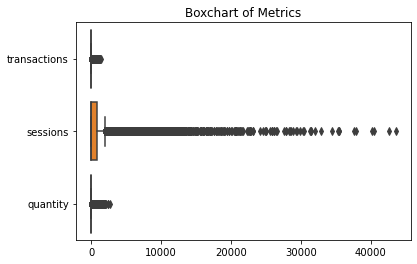

In [21]:
#Creating a box plot. 

import seaborn as sns

sns.boxplot(data=sessioncounts[["transactions", "sessions", "quantity"]], orient="h")
plt.title("Boxchart of Metrics")
plt.show()

This visually confirms our thinking above, that the majority of the data points lie closest to 0. In this graph, the outliers are colored black. You can see that the spread of outliers in sessions is large and over powers the actual box (which is where 75% of the data is). The scale of sessions is far larger than the transactions and quantity. So not everyone who shops their website, purchases goods.

This means the number of transactions and the quantity purchased during them has a fairly linear relationship since the shape of the two boxes is similar. Sessions isn't much different, it just has more outliers. 

Another interesting display would be a line graph of all 3 metrics. 

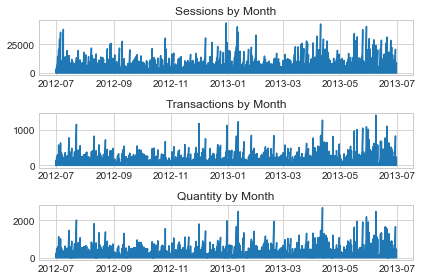

<Figure size 1440x1152 with 0 Axes>

In [22]:
#Creating a line graph

plt.style.use('seaborn-whitegrid')

#Plot 1:
x = sessioncounts['date']
y = sessioncounts['sessions']

plt.subplot(3, 1, 1)
plt.title("Sessions by Month")
plt.plot(x,y)

#Plot 2:
x = sessioncounts['date']
y = sessioncounts['transactions']

plt.subplot(3, 1, 2)
plt.title("Transactions by Month")
plt.plot(x,y)

#Plot 3:
x = sessioncounts['date']
y = sessioncounts['quantity']

plt.subplot(3, 1, 3)
plt.title("Quantity by Month")
plt.plot(x,y)

plt.tight_layout()

#Graph it
plt.figure(figsize=(20,16))
plt.show()


There are obviously ways to make these more beautiful and readable but in this instance since all 3 graphs have the same shape and spread, we cannot draw many conclusions so it isn't really worth the time.

From all 3, we can see that there are a few noticeable spikes which seem to align with major holidays throughout the year (so major sale dates?): labor day, Christmas, Memorial Day, Fourth of July, etc. 

### Adds To Cart

In [23]:
#Inspect it

addstocart.head()

,date,addstocart
0,2012-07-01,191504
1,2012-08-01,217666
2,2012-09-01,123726
3,2012-10-01,139803
4,2012-11-01,186572


One thing we can immediately note in comparison to the Session Counts data, is that the numbers of times an item is added to the cart is a far greater number than the number of transactions. So people are interested in purchasing the item but they could be waiting for a sale, get distracted and didn't complete checkout, or they just got cold feet and decided against the purchase. This is a useful value to have because people with items in their cart can be incentivized to complete check out with pop up or email discount codes. 

Now let's look at the describe. 

In [24]:
#Get simple statistics

addstocart.describe().T

,count,mean,std,min,25%,50%,75%,max
addstocart,12.0,154172.75,35024.025354,107970.0,132843.0,143711.0,184524.5,217666.0


Unlike Session Counts, this shows a more even distribution in data, ranging ~100,00, with fairly even jumps between the quartiles. Let's look at the tail to check something. 

In [25]:
#Checking Tail

addstocart.tail()

,date,addstocart
7,2013-02-01,135882
8,2013-03-01,109797
9,2013-04-01,183842
10,2013-05-01,136720
11,2013-06-01,107970


It looks like there is no trend over time with adds to carts increasing or decreasing, it seems to be remain fairly even with small shifts. Let's graph that to see for sure. 

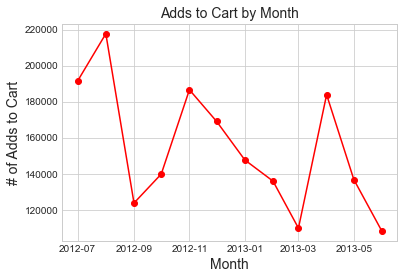

In [26]:
#Creating a line graph

plt.style.use('seaborn-whitegrid')

plt.plot(addstocart['date'], addstocart['addstocart'], color='red', marker='o')
plt.title('Adds to Cart by Month', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.ylabel('# of Adds to Cart', fontsize=14)
plt.grid(True)
plt.show()

Looks like there were decreases in 9/2012 and 3/2013. This could be a place for further exploration. Especially in 9/2012-- September is a big sale month with labor day. Did more people check out during sales? March has a similar pattern-- Memorial Day perhaps? Seems to be an inverse relationship with common sale times. It would be worthwhile to add more years to this data to see if these are yearly trends or not. 

### Redefining The Problem

Now that we understand the data given, we can adjust our problem to be an ecommerce website (Fictional) needing to look at the monthly analysis of sessions on the website and the number of purchases and total number of items bought. Additionally, they want to look at the number of times items were added to the cart in a month over month basis. 

## 4 - Answering the Problem 

We need to create 2 reports, but a third may provide more insight.  
1. A report displaying Sessions, Transactions, Quantity, and ECR (Transactions / Sessions) grouped by Month and Device.
2. A report displaying Month over Month comparison for all metrics (including the above and Adds to Cart) in the past 2 months plus the absolute and relative differences between. 
3. Any additional reports found-- these will be put into a third report because it's never a good idea to not follow exactly what a client expects!

In this section we will generate the requested reports, but any analysis is saved for the last section "Findings". 

### Report #1
We'll focus on the first one initially. We don't need browser so we drop that. Then we need to group by month and device. Lastly we need to create the new ECR calculated column. 

In [27]:
#Step 1 - Drop unnecessary columns

report_1 = sessioncounts.drop(['browser'], axis=1)

In [28]:
#Step 2 - Group by date and device.

report_1= report_1.groupby(by=['date', 'device']).agg('sum')[['sessions', 'transactions', 'quantity']]

#Checking

report_1.head()

sessions  transactions  quantity
date       device                                   
2012-07-01 desktop      1117            28         0
           mobile        201             6        11
           tablet       3758           141       239
2012-07-02 desktop      6004           120       272
           mobile       2373             7        12

In [29]:
#Step 3 - Created ECR Column (transactions/sessions)

report_1['ecr']= (report_1['transactions'] / report_1['sessions'] * 100).round(2)


#Step 4 - Reorder the columns so ECR is near Sessions & Transactions and swap the two.

report_1=report_1.iloc[:,[1,0,3,2]]


#Checking

report_1

transactions  sessions   ecr  quantity
date       device                                         
2012-07-01 desktop            28      1117  2.51         0
           mobile              6       201  2.99        11
           tablet            141      3758  3.75       239
2012-07-02 desktop           120      6004  2.00       272
           mobile              7      2373  0.29        12
...                          ...       ...   ...       ...
2013-06-29 mobile             74      9131  0.81       125
           tablet              5       294  1.70         4
2013-06-30 desktop           533     19241  2.77       966
           mobile             94     10692  0.88       187
           tablet             98      3534  2.77       162

[1095 rows x 4 columns]

This satisfies the requirements of Fictional's ask for Report #1. We have transactions, sessions, ecr and quantity grouped by both date and device. Let's save the file. 

In [30]:
#Saving it to xlsx

from openpyxl import load_workbook

path = r"/Users/elizabethmiller/Desktop/elizabethmiller_report.xlsx"

book = load_workbook(path)
writer = pd.ExcelWriter(path, engine = 'openpyxl')
writer.book = book

report_1.to_excel(writer, sheet_name = 'report_1')

writer.close()

### Report #2

For the second report we need to complete a few steps first to create the dataframe we want in order to do the month over month analysis. We need to drop the browser and device columns as those were not mentioned in the instructions, and we need to change the date columns to be month/year without days. This is important because there is a granularity difference between the Session Counts table and the Adds to Cart table-- Session counts is at the daily level and Adds to Cart is monthly. To do this we will sum sessions, transactions and quantity by the date. 

In [31]:
#Step 1 - Drop unnecessary columns

report_2=sessioncounts.drop(['browser', 'device'], axis=1)


#Step 2 - Change the date to month/year

report_2['date'] = report_2['date'].dt.strftime("%m-%Y")


#Step 3 - group by date and sum by the metrics.

report_2=report_2.groupby(by=['date']).agg('sum')[['sessions', 'transactions', 'quantity']]


#Check it out

report_2


,sessions,transactions,quantity
date,,,
01-2013,899992,21560,38846
02-2013,550227,14166,27048
03-2013,788820,17804,32082
04-2013,1296613,30369,54946
05-2013,1164639,28389,51629
06-2013,1388834,34538,61891
07-2012,768589,18161,31804
08-2012,822493,19279,34648
09-2012,662653,15658,28426


Looks good. Now let's change the Adds To Cart table to match-- it's date column is month/firstday/year which won't join to our above table. Then we can join the 2 tables. 

In [32]:
#Do the same to the addstocart table

addstocart['date'] = addstocart['date'].dt.strftime("%m-%Y")
addstocart


#Now join the 2 tables

report_2=report_2.merge(addstocart, on='date', how='left')
report_2

,date,sessions,transactions,quantity,addstocart
0,01-2013,899992,21560,38846,147619
1,02-2013,550227,14166,27048,135882
2,03-2013,788820,17804,32082,109797
3,04-2013,1296613,30369,54946,183842
4,05-2013,1164639,28389,51629,136720
5,06-2013,1388834,34538,61891,107970
6,07-2012,768589,18161,31804,191504
7,08-2012,822493,19279,34648,217666
8,09-2012,662653,15658,28426,123726
9,10-2012,648639,14275,26626,139803


Lastly, we need to add back in the ECR column and rearrange the columns again. 

In [33]:
#Step 1 - Create ECR Column (transactions/sessions)

report_2['ecr']= (report_2['transactions'] / report_2['sessions'] * 100).round(2)


#Step 2 - Reorder the columns so ECR is near Sessions & Transactions and swap the two.

report_2=report_2.iloc[:,[0, 4, 1, 5, 2, 3]]


#Step 3 - Saving for report 3 analysis

report_3 = report_2

#Checking

report_2

,date,addstocart,sessions,ecr,transactions,quantity
0,01-2013,147619,899992,2.40,21560,38846
1,02-2013,135882,550227,2.57,14166,27048
2,03-2013,109797,788820,2.26,17804,32082
3,04-2013,183842,1296613,2.34,30369,54946
4,05-2013,136720,1164639,2.44,28389,51629
5,06-2013,107970,1388834,2.49,34538,61891
6,07-2012,191504,768589,2.36,18161,31804
7,08-2012,217666,822493,2.34,19279,34648
8,09-2012,123726,662653,2.36,15658,28426
9,10-2012,139803,648639,2.20,14275,26626


The report is now in the correct format but it's going to sort the data incorrectly due to the string type date column, so let's convert it back to datetime, sort by it and keep only the last 2 rows (most current) as specified by the report. 

In [34]:
#Reset the index.

report_2.reset_index(drop=True, inplace=True)


#Set the date column as datetime again. 

report_2['date']=pd.to_datetime(report_2['date'])


#Sort by the 'date' column.

report_2.sort_values('date', inplace=True)


# Capture only the last two rows

report_2 = report_2.tail(2)


#Checking

report_2

,date,addstocart,sessions,ecr,transactions,quantity
4,2013-05-01,136720,1164639,2.44,28389,51629
5,2013-06-01,107970,1388834,2.49,34538,61891


Now we can begin the month over month analysis. There are many ways to do this such as using shift or transform... or we can just write a simple loop and take the difference. 

In [35]:
#Finding the difference of each metric.

columns_to_change = ['addstocart', 'sessions', 'ecr', 'transactions', 'quantity']

for column in columns_to_change:
    report_2[f'{column}_diff'] = report_2[column].diff()

    
#Finding the absolute difference of each metric.

columns_to_change = ['addstocart', 'sessions', 'ecr', 'transactions', 'quantity']

for column in columns_to_change:
    report_2[f'{column}_absdiff'] = report_2[column].diff().abs()


#Checking

report_2

,date,addstocart,sessions,ecr,transactions,quantity,addstocart_diff,sessions_diff,ecr_diff,transactions_diff,quantity_diff,addstocart_absdiff,sessions_absdiff,ecr_absdiff,transactions_absdiff,quantity_absdiff
4,2013-05-01,136720,1164639,2.44,28389,51629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2013-06-01,107970,1388834,2.49,34538,61891,-28750.0,224195.0,0.05,6149.0,10262.0,28750.0,224195.0,0.05,6149.0,10262.0


This looks great but it's a little difficult to read since the same column values are spread apart. Let's reorder it so all the same columns metrics are together.

In [36]:
#Reordering

report_2=report_2.iloc[:,[0, 1, 6, 11, 2, 7, 12, 3, 8, 13, 4, 9, 14, 5, 10, 15]]

#Checking

report_2

,date,addstocart,addstocart_diff,addstocart_absdiff,sessions,sessions_diff,sessions_absdiff,ecr,ecr_diff,ecr_absdiff,transactions,transactions_diff,transactions_absdiff,quantity,quantity_diff,quantity_absdiff
4,2013-05-01,136720,NaN,NaN,1164639,NaN,NaN,2.44,NaN,NaN,28389,NaN,NaN,51629,NaN,NaN
5,2013-06-01,107970,-28750.0,28750.0,1388834,224195.0,224195.0,2.49,0.05,0.05,34538,6149.0,6149.0,61891,10262.0,10262.0


This satisfies the requirements for report #2. We have prior month, current month and then the relative and absolute differences between the 2. 

**Note: Since we are only using 2 months for this analysis, the previous month's difference show as null since there was nothing to compare against.**

In [37]:
#Saving it as xlsx

path = r"/Users/elizabethmiller/Desktop/elizabethmiller_report.xlsx"

book = load_workbook(path)
writer = pd.ExcelWriter(path, engine = 'openpyxl')
writer.book = book

report_2.to_excel(writer, sheet_name = 'report_2')

writer.close()

### Report #3

For the third report, we can do anything we want. An interesting metric that we have not investigated yet is how often items were added to the cart vs. actually purchased (transactions)-- we'll call this purchase rate. The previous report showed a trend here. Additionally, does the quantity of items purchased relate to the number of sessions (volume by sessions)?

To do this, we'll use the report_3 generated earlier and create new columns for each of those metrics. 

In [38]:
#Creating Purchase Rate
report_3['purchase_rate'] = ((report_3['transactions'] / report_3['addstocart'])*100).round(2)


#Creating Volume by Sessions
report_3['volume_by_sessions'] = ((report_3['quantity'] / report_3['sessions'])*100).round(2)


#Checking
report_3

,date,addstocart,sessions,ecr,transactions,quantity,purchase_rate,volume_by_sessions
6,2012-07-01,191504,768589,2.36,18161,31804,9.48,4.14
7,2012-08-01,217666,822493,2.34,19279,34648,8.86,4.21
8,2012-09-01,123726,662653,2.36,15658,28426,12.66,4.29
9,2012-10-01,139803,648639,2.20,14275,26626,10.21,4.10
10,2012-11-01,186572,637780,2.43,15527,28132,8.32,4.41
11,2012-12-01,168972,789634,2.52,19929,34752,11.79,4.40
0,2013-01-01,147619,899992,2.40,21560,38846,14.61,4.32
1,2013-02-01,135882,550227,2.57,14166,27048,10.43,4.92
2,2013-03-01,109797,788820,2.26,17804,32082,16.22,4.07
3,2013-04-01,183842,1296613,2.34,30369,54946,16.52,4.24


Let's save this as a report in the excel file, and we'll analyze our findings below. 

In [39]:
#Saving it as xlsx

path = r"/Users/elizabethmiller/Desktop/elizabethmiller_report.xlsx"

book = load_workbook(path)
writer = pd.ExcelWriter(path, engine = 'openpyxl')
writer.book = book

report_3.to_excel(writer, sheet_name = 'report_3')

writer.close()

## 5 - Findings

### Report 1

In [40]:
#Reminder of report 1
report_1

transactions  sessions   ecr  quantity
date       device                                         
2012-07-01 desktop            28      1117  2.51         0
           mobile              6       201  2.99        11
           tablet            141      3758  3.75       239
2012-07-02 desktop           120      6004  2.00       272
           mobile              7      2373  0.29        12
...                          ...       ...   ...       ...
2013-06-29 mobile             74      9131  0.81       125
           tablet              5       294  1.70         4
2013-06-30 desktop           533     19241  2.77       966
           mobile             94     10692  0.88       187
           tablet             98      3534  2.77       162

[1095 rows x 4 columns]

Using the report, we can visualize it to more easily determine some analysis. 

<AxesSubplot:title={'center':'ECR by Month'}, xlabel='date'>

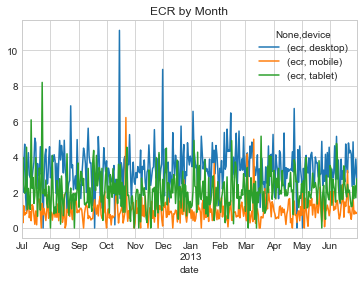

In [41]:
#Visualize it 

viz_report_1= report_1.groupby(by=['date', 'device']).agg('sum')[['ecr']].unstack().plot(title="ECR by Month")
viz_report_1

This graph tells us *how* people are shopping with Fictional. We can see that mobile has the lowest ECR, and desktop has this highest. This is important because Fictional should look into increasing ways to drive transactions in the mobile and tablet space. Do customers prefer desktop because it's easier to input their credit card details that way? Maybe look into a service like Shop Pay where customers just need to enter their email to pull up their bank/card details. Or even Paypal since Paypal will work with Apple's face recognition now. Perhaps this is a UX design issue and the website works best on desktop-- maybe investing in a UX designer can improve the mobile and tablet shopping experience. 

There are a couple of times in the year where tablet and mobile outperform desktop-- like in mid July, tablets had a surge of ECR. Are teens home for the summer avoiding their laptops? In December mobile had a surge-- is this due to the busy holiday season?

These are all actionable questions that can lead to revenue. 

### Report 2



In [42]:
#Reminder of report 2
report_2

,date,addstocart,addstocart_diff,addstocart_absdiff,sessions,sessions_diff,sessions_absdiff,ecr,ecr_diff,ecr_absdiff,transactions,transactions_diff,transactions_absdiff,quantity,quantity_diff,quantity_absdiff
4,2013-05-01,136720,NaN,NaN,1164639,NaN,NaN,2.44,NaN,NaN,28389,NaN,NaN,51629,NaN,NaN
5,2013-06-01,107970,-28750.0,28750.0,1388834,224195.0,224195.0,2.49,0.05,0.05,34538,6149.0,6149.0,61891,10262.0,10262.0


In the most recent month there were less adds to cart, by about 21% which is a significant drop. The other metrics increased by that margin; The number of sessions increased by about 20%, transactions by 22% and quantity by 20%. This tells us that something happened in from May to June that increased the time spent on the website, the number of purchases and the volume purchased during that time. Most likely, a sale occurred then since Memorial Day is the last day of May. Since it reduced the number of times that people had items sitting in their cart but did not check out, this looks like a successful sale in terms of the metrics given. If we were to add in revenue to the mix, we could really see if it was successful in terms of dollars earned in May vs. June. 

**Note: One small change that could be made to this report to give it more impact is to add the percent change along with the simple difference and absolute difference between the two months. The pandas library includes a pct_change function. As this doesn't change the report asked for, this would be easy to add in but due to time constraints, it wasn't possible.**

### Report 3

In [43]:
#Reminder of report 3

report_3

,date,addstocart,sessions,ecr,transactions,quantity,purchase_rate,volume_by_sessions
6,2012-07-01,191504,768589,2.36,18161,31804,9.48,4.14
7,2012-08-01,217666,822493,2.34,19279,34648,8.86,4.21
8,2012-09-01,123726,662653,2.36,15658,28426,12.66,4.29
9,2012-10-01,139803,648639,2.20,14275,26626,10.21,4.10
10,2012-11-01,186572,637780,2.43,15527,28132,8.32,4.41
11,2012-12-01,168972,789634,2.52,19929,34752,11.79,4.40
0,2013-01-01,147619,899992,2.40,21560,38846,14.61,4.32
1,2013-02-01,135882,550227,2.57,14166,27048,10.43,4.92
2,2013-03-01,109797,788820,2.26,17804,32082,16.22,4.07
3,2013-04-01,183842,1296613,2.34,30369,54946,16.52,4.24


From this report we wanted to see how purchase rate has changed over time and if the amount of items by the number of sessions is significant. 

From the table above, we can see that volume by sessions stays steady at around 4 so that value is not a significant finding. This happens! Not every metric created can be insightful. 

For purchase rate, we can see that the rate is increasing with every month. Let's quickly map that. 

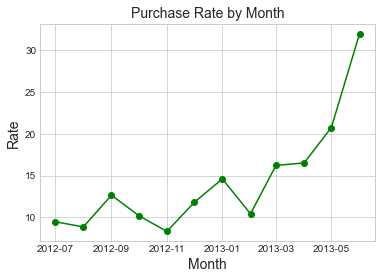

In [44]:
#Creating a line graph

plt.style.use('seaborn-whitegrid')

plt.plot(report_3['date'],report_3['purchase_rate'], color='green', marker='o')
plt.title('Purchase Rate by Month', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Rate', fontsize=14)
plt.grid(True)
plt.show()

We can see that purchase rate is following an almost exponential curve. This is significant because Fictional is increasing the number of purchases (transactions) and decreasing the amount of times items sit in cart without being purchased. As previously discussed, there likely was a successful sale in May/June due to Memorial Day. However this line graph shows this far better than the table did. Note that the purchase rate did not increase through the holiday season which is unusual. Did Fictional not run competitive sales during this time? This is something Fictional needs to work on for the next holiday season. Perhaps they could use the same strategy used in May/June. As mentioned before, revenue would really confirm whether May/June was successful. 

### Summary of Findings

1. Hire a UX designer to improve the mobile and tablet website experience. 
2. Add some more user friendly check out options such as Shop Pay or Paypal.
3. Copy the sale strategy from Memorial Day for the next holidays, especially the Holiday season.
4. Check on the method used for obtaining browser data-- 6% of data is not compiling correctly.
5. Add in revenue and user data to gain more insight.

## Further Steps

As the data currently stands we can do some fairly useful analysis, but we cannot take it further without more data. The answer to doing anything further is always to get more data. More than a year's worth of data would be a good start.

With the addition of a user id or some way of identifying individuals (customers), we could go into further analysis about what specific items people look at, their purchase rates, etc. You could even set up a running cohort analysis. With even more data about the individual (maybe with a voluntary survey of users), we could see which states, rough age range, etc that users belong in. We could also look at retention of customers. 

If we added in data about *what* items (products) people were buying or putting in their carts we could do even more analysis. Fictional would know which items sell the most and with which age groups. This is useful for planning new inventory. With this they can change their focus or narrow in on certain cohorts. 

Building off this, if we had dates from the company from when they ran specific sales we could compare transactions vs. adds to cart to see which sales performed best with which customers. 